In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 8.3 MB/s eta 0:00:00


In [3]:
import os

home = '/content/drive/MyDrive/2ReadyForFineTuning/VLQAv1/Charts/'

imroot = home+'images'
os.chdir(home)

In [4]:
prefix = 'charts'

In [5]:
import json
import ast
datalen = 0
dumpdict = { "info": {}, "task_type": "Open-Ended", "data_type": "charts", "license": {}, "data_subtype": prefix, "questions": [] }

with open(home+prefix+'.jsonl') as f:
  data = f.readlines()
  print(len(data))
  global datalen
  datalen = len(data)
  for i in data[0:int(datalen*0.8)]:
    ijson = json.loads(i)
    imlist = ast.literal_eval(ijson['images'])
    #print(imlist)
    anslist = ast.literal_eval(ijson['answer_choices'])
    #print(anslist)
    if len(anslist)==2:
      anslist.append("Unknown")
      anslist.append("Unanswerable")
    try:
      #print(len(anslist))
      assert len(anslist) == 4
    except:
      print(i)
    dumpdict['questions'].append( { "image_id": imroot+"/"+imlist[0].replace("./images/", ""), "question": ijson['question']+" "+ijson['passage'], "question_id": ijson['qid'], "answer_choices": anslist, "answer_id": int(ijson['answer']) } )

with open('/content/'+prefix+'_train.jsonl','w+') as w:
  w.write(json.dumps(dumpdict,indent=4))

print(dumpdict)

251
{'info': {}, 'task_type': 'Open-Ended', 'data_type': 'charts', 'license': {}, 'data_subtype': 'charts', 'questions': [{'image_id': '/content/drive/MyDrive/2ReadyForFineTuning/VLQAv1/Charts/images/21.png', 'question': 'From the above graph infer comparatively which country is most likely to have highest per capita income? The above visualization shows health care expenditure across countries. There is a strong correlation between health care expenditure and national income. The countries which spend more on health care are more likely to have highest per capita income.', 'question_id': 2218, 'answer_choices': ['United States', 'United Kingdom', 'India', 'Iraq'], 'answer_id': 0}, {'image_id': '/content/drive/MyDrive/2ReadyForFineTuning/VLQAv1/Charts/images/21.png', 'question': 'How many countries are most likely to have better per capita income level than Iraq? The above visualization shows health care expenditure across countries. There is a strong correlation between health care ex

In [6]:
import json
f = open('/content/'+prefix+'_train.jsonl','r')
data_questions = json.load(f)
questions = data_questions['questions']

print(data_questions.keys())
print("Number of questions:", len(questions))

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])
Number of questions: 200


In [7]:
questions[0]

{'image_id': '/content/drive/MyDrive/2ReadyForFineTuning/VLQAv1/Charts/images/21.png',
 'question': 'From the above graph infer comparatively which country is most likely to have highest per capita income? The above visualization shows health care expenditure across countries. There is a strong correlation between health care expenditure and national income. The countries which spend more on health care are more likely to have highest per capita income.',
 'question_id': 2218,
 'answer_choices': ['United States', 'United Kingdom', 'India', 'Iraq'],
 'answer_id': 0}

In [8]:
from os import listdir
from os.path import isfile, join

file_names = [f for f in listdir(imroot) if isfile(join(imroot, f))]
print(file_names)
print(len(file_names))

['central-bank-discount-rate_Mexico.png', 'stock-of-broad-money_United_States.png', 'gdp-real-growth-rate_Puerto_Rico.png', 'gross-national-saving_United_States.png', 'exports_United_Kingdom.png', 'distribution-of-family-income-gini-index_India.png', 'distribution-of-family-income-gini-index_United_States.png', 'stock-of-direct-foreign-investment-abroad_United_States.png', 'gross-national-saving_South_Africa.png', 'gdp-real-growth-rate_Saudi_Arabia_Qatar.png', 'current-account-balance_India_European_Union.png', 'military-expenditures_United_States.png', 'commercial-bank-prime-lending-rate_Argentina.png', 'commercial-bank-prime-lending-rate_Argentina_Brazil.png', 'central-bank-discount-rate_France.png', 'gdp-real-growth-rate_Brazil.png', 'gdp-real-growth-rate_Venezuela.png', 'central-bank-discount-rate_Germany_France.png', 'reserves-of-foreign-exchange-and-gold_India.png', 'distribution-of-family-income-gini-index_United_States_Canada_Mexico.png', 'inflation-rate-consumer-prices_United_

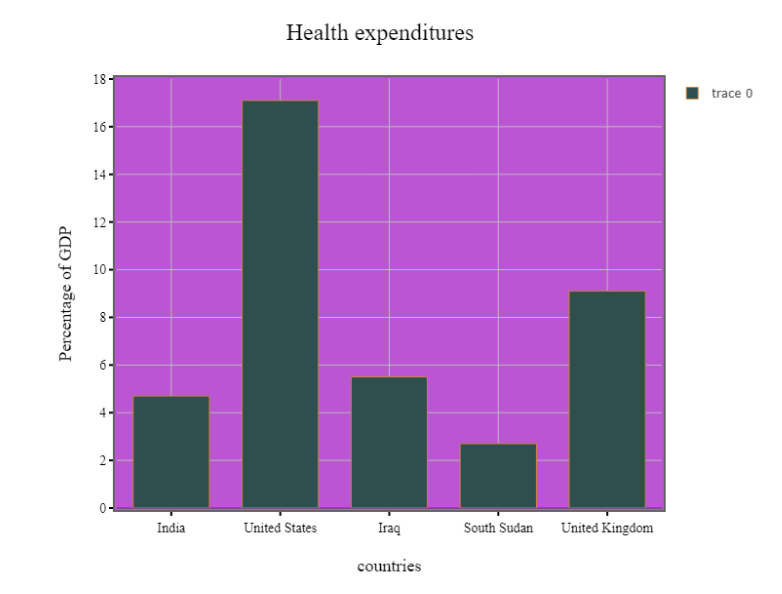

In [9]:
from PIL import Image

path = questions[0]['image_id']
image = Image.open(path)
image

In [10]:
import torch
import torchvision
from PIL import Image
import torch.nn.functional as F
from torch import ones, long as lg, float as fl
import torchvision.transforms as transforms

class VQADataset(torch.utils.data.Dataset):

    def __init__(self, questions, processor):
        self.questions = questions
        self.processor = processor

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        questions = self.questions[idx]
        image = Image.open(questions['image_id']).convert("RGB")
        resize_transform = transforms.Resize((384, 384))
        image = resize_transform(image)
        text = questions['question']
        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")

        encoding['visual_embeds'] = encoding['pixel_values']
        encoding['visual_embeds'] = encoding['visual_embeds'][:,0,:,:]
        encoding.pop('pixel_values')
        encoding.pop('pixel_mask')
        encoding['visual_token_type_ids'] = ones(encoding['visual_embeds'].shape[:-1], dtype=lg)
        encoding['visual_attention_mask'] = ones(encoding['visual_embeds'].shape[:-1], dtype=fl)

        for k,v in encoding.items():
          encoding[k] = v.squeeze()
        targets = torch.zeros(len(questions['answer_choices']))
        targets[questions['answer_id']] = 1.0
        encoding["labels"] = targets
        return encoding

In [11]:
from transformers import ViltProcessor
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [12]:
dataset = VQADataset(questions=questions,processor=processor)

In [13]:
dataset[0]

{'input_ids': tensor([  101,  2013,  1996,  2682, 10629,  1999,  7512, 20172,  2029,  2406,
         2003,  2087,  3497,  2000,  2031,  3284,  2566,  8353,  3318,  1029,
         1996,  2682,  5107,  3989,  3065,  2740,  2729, 20700,  2408,  3032,
         1012,  2045,  2003,  1037,  2844, 16902,  2090,  2740,  2729,   102]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'visual_embeds': tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]), 'visual_token_type_ids': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [14]:
dataset[1].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'visual_embeds', 'visual_token_type_ids', 'visual_attention_mask', 'labels'])

In [15]:
processor.decode(dataset[0]['input_ids'])

'[CLS] from the above graph infer comparatively which country is most likely to have highest per capita income? the above visualization shows health care expenditure across countries. there is a strong correlation between health care [SEP]'

In [16]:
labels = torch.nonzero(dataset[0]['labels']).squeeze().tolist()
labels

0

In [17]:
from transformers import VisualBertForQuestionAnswering
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisualBertForQuestionAnswering.from_pretrained("daki97/visualbert_finetuned_easy_vqa", num_labels=4,ignore_mismatched_sizes=True, visual_embedding_dim = 384)
model.to(device)

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/441M [00:00<?, ?B/s]

Some weights of VisualBertForQuestionAnswering were not initialized from the model checkpoint at daki97/visualbert_finetuned_easy_vqa and are newly initialized because the shapes did not match:
- cls.weight: found shape torch.Size([13, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- cls.bias: found shape torch.Size([13]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisualBertForQuestionAnswering(
  (visual_bert): VisualBertModel(
    (embeddings): VisualBertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (visual_token_type_embeddings): Embedding(2, 768)
      (visual_position_embeddings): Embedding(512, 768)
      (visual_projection): Linear(in_features=384, out_features=768, bias=True)
    )
    (encoder): VisualBertEncoder(
      (layer): ModuleList(
        (0-11): 12 x VisualBertLayer(
          (attention): VisualBertAttention(
            (self): VisualBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
  

In [18]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import ones, long as lg, float as fl,  stack, FloatTensor

def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  visual_embeds = [item['visual_embeds'] for item in batch]
  attention_mask = [item['attention_mask'] for item in batch]
  token_type_ids = [item['token_type_ids'] for item in batch]
  visual_token_type_ids = [item['visual_token_type_ids'] for item in batch]
  visual_attention_mask = [item['visual_attention_mask'] for item in batch]
  labels = [item['labels'] for item in batch]

  batch = {}
  batch['visual_embeds'] = torch.stack(visual_embeds)
  batch['input_ids'] = torch.stack(input_ids)
  batch['token_type_ids'] = torch.stack(token_type_ids)
  batch['visual_token_type_ids'] = torch.stack(visual_token_type_ids)
  batch['attention_mask'] = torch.stack(attention_mask)
  batch['visual_attention_mask'] = torch.stack(visual_attention_mask)
  batch['labels'] = torch.stack(labels)

  return batch

train_dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)

In [19]:
batch = next(iter(train_dataloader))

In [20]:
for k,v in batch.items():
  print(k, v.shape)

visual_embeds torch.Size([1, 384, 384])
input_ids torch.Size([1, 40])
token_type_ids torch.Size([1, 40])
visual_token_type_ids torch.Size([1, 384])
attention_mask torch.Size([1, 40])
visual_attention_mask torch.Size([1, 384])
labels torch.Size([1, 4])


In [21]:
from tqdm.notebook import tqdm
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# -- CHANGE BASED ON HOW MANY EPOCHS YOU WANT TO RUN FOR
e = 5

model.train()
for epoch in range(e):
   print(f"Epoch: {epoch}")
   for batch in tqdm(train_dataloader):
        batch = {k:v.to(device) for k,v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        #print("Loss:", loss.item())
        loss.backward()
        optimizer.step()

Epoch: 0


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/200 [00:00<?, ?it/s]

## Inference

In [22]:
import json
import ast
datalen = 0
dumpdict = { "info": {}, "task_type": "Open-Ended", "data_type": "charts", "license": {}, "data_subtype": prefix, "questions": [] }

with open(home+prefix+'.jsonl') as f:
  data = f.readlines()
  print(len(data))
  global datalen
  datalen = len(data)
  for i in data[int(datalen*0.8):datalen]:
    test_ijson = json.loads(i)
    test_imlist = ast.literal_eval(test_ijson['images'])
    #print(imlist)
    test_anslist = ast.literal_eval(test_ijson['answer_choices'])
    if len(test_anslist)==2:
      test_anslist.append("Unknown")
      test_anslist.append("Unanswerable")
    #print(anslist)
    try:
      #print(len(anslist))
      assert len(test_anslist) == 4
    except:
      print(i)
    dumpdict['questions'].append( { "image_id": imroot+"/"+test_imlist[0].replace("./images/", ""), "question": test_ijson['question']+" "+test_ijson['passage'], "question_id": test_ijson['qid'], "answer_choices": test_anslist, "answer_id": int(test_ijson['answer']) } )

with open('/content/'+prefix+'_test.jsonl','w+') as w:
  w.write(json.dumps(dumpdict,indent=4))

print(dumpdict)

251
{'info': {}, 'task_type': 'Open-Ended', 'data_type': 'charts', 'license': {}, 'data_subtype': 'charts', 'questions': [{'image_id': '/content/drive/MyDrive/2ReadyForFineTuning/VLQAv1/Charts/images/1.png', 'question': 'The industrial production growth rate of Pakistan is almost equal to Figure shows the industrial production growth rate for various countries in the year of 2017. Industrial production figures are used by central banks to measure inflation, as high levels of industrial production can lead to uncontrolled levels of consumption and rapid inflation. In 2017, the industrial production growth rate of India was similar to that of Pakistan.', 'question_id': 2418, 'answer_choices': [7.5, 6.5, 5.5, 4.5], 'answer_id': 2}, {'image_id': '/content/drive/MyDrive/2ReadyForFineTuning/VLQAv1/Charts/images/1.png', 'question': 'Consider all the given 6 countries. The industrial production growth rate of Sri Lanka is less than how many countries Figure shows the industrial production grow

In [23]:
import json
f = open('/content/'+prefix+'_test.jsonl','r')
test_data_questions = json.load(f)
test_questions = test_data_questions['questions']

print(test_data_questions.keys())
print("Number of questions:", len(test_questions))

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])
Number of questions: 51


In [24]:
test_dataset = VQADataset(questions=test_questions,processor=processor)

In [25]:
len(test_dataset)

51

# Single Instance Inference

In [26]:
exid = 1
example = test_dataset[exid]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'visual_embeds', 'visual_token_type_ids', 'visual_attention_mask', 'labels'])


In [27]:
# add batch dimension + move to GPU
example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}

# forward pass
outputs = model(**example)

In [28]:
logits = outputs.logits
predicted_class = logits.argmax(-1).item()
print("Predicted answer:", predicted_class)
print("Ground-truth answer:", test_dataset[exid]['labels'].argmax(-1).item())

Predicted answer: 1
Ground-truth answer: 3


# Batch Inference

In [29]:
import csv
filprefix = prefix+"_result"

count = 0
st = 0
end = datalen-int(datalen*0.8)
with open(filprefix+'.csv', 'w+') as k:
  spamwriter = csv.writer(k)
  spamwriter.writerow(["qid","pred_ans","gt_ans","correctness"])
  for exid in range(st,end):
    correctness = 0
    example = test_dataset[exid]
    example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}
    outputs = model(**example)
    logits = outputs.logits
    predicted_class = logits.argmax(-1).item()
    gtclass = test_dataset[exid]['labels'].argmax(-1).item()
    if gtclass==predicted_class:
      count+=1
      correctness = 1
    spamwriter.writerow([exid,predicted_class, gtclass,correctness])